<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_03-28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [10:59<00:00, 24.0MB/s]
100% 14.9G/14.9G [10:59<00:00, 24.2MB/s]


In [ ]:
import os
os.mkdir('/content/train')
os.mkdir('/content/test')
os.mkdir('/content/eval')

In [ ]:
!unzip /content/plant-pathology-2021-fgvc8.zip -d /content/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/train_images/e00c97b2de4749ce.jpg  
  inflating: /content/train_images/e00df890cfe62736.jpg  
  inflating: /content/train_images/e00ed0bf43a87f25.jpg  
  inflating: /content/train_images/e00f759d65d52887.jpg  
  inflating: /content/train_images/e00f934d9e50ad5b.jpg  
  inflating: /content/train_images/e00fce341cb63da5.jpg  
  inflating: /content/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /content/train_images/e01112939f783fec.jpg  
  inflating: /content/train_images/e01592da4d71b8be.jpg  
  inflating: /content/train_images/e0189acaf8cf80fd.jpg  
  inflating: /content/train_images/e0189e4999bdd0fa.jpg  
  inflating: /content/train_images/e01ae16d4a759cb5.jpg  
  inflating: /content/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /content/train_images/e01e42d90c66f3f3.jpg  
  inflating: /content/train_images/e01e870bec65f40f.jpg  
  inflating: /content/train_images/e01f17e0187fb80f.jpg  
  inflating: /content/train_images/e

In [ ]:
import pandas as pd

In [ ]:
train=pd.read_csv('/content/train.csv')

In [ ]:
for dir in ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']:
  os.makedirs('/content/train/'+dir)
  os.makedirs('/content/test/'+dir)
  os.makedirs('/content/eval/'+dir)

In [ ]:
new=pd.DataFrame(columns=['image','labels'])
for idx,(image,label) in enumerate(train.values):
  n=len(label.split())
  if n!=1:
    cols= ['image','labels']	
    for i in label.split():
      add_row = [[image,i]]	

      row_df = pd.DataFrame(data = add_row, columns = cols)	
                            
      new = pd.concat([new, row_df], ignore_index = True)
    train.drop(labels=idx,axis=0,inplace=True)

In [ ]:
train=pd.concat([new,train],ignore_index=True)

In [ ]:
train,other=train_test_split(train,  train_size= 0.6, shuffle= True)
test,eval=train_test_split(other,  train_size= 0.5, shuffle= True)

In [ ]:
import shutil
def move(data,where):
  path='/content/train_images/'
  for name,label in data.values:
    if os.path.exists(path+name):
        shutil.move(path+name,"/content/"+where+"/"+label+'/'+name)

In [ ]:
for key,value in {'train':train,'test':test,'eval':eval}.items():
  move(value,key)

In [ ]:
train['labels'].isnull().sum()

0

In [ ]:
train['labels'].value_counts()

scab                  3411
healthy               2834
frog_eye_leaf_spot    2609
complex               1274
rust                  1218
powdery_mildew         766
Name: labels, dtype: int64

In [ ]:
import matplotlib.pyplot as plt


<Axes: >

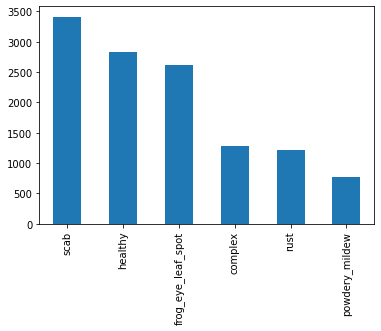

In [ ]:
train['labels'].value_counts().plot(kind='bar')

In [ ]:
len(train)

12112

In [ ]:
test

,image,labels
12206,c5a3c8525c5d9d71.jpg,healthy
13649,d0d8623faf1f030b.jpg,rust
6464,9f81ea811f3d3278.jpg,healthy
1453,bf479197cb1a7048.jpg,scab
14358,d5e36bf53ca41406.jpg,frog_eye_leaf_spot
...,...,...
16106,e306368eef675016.jpg,healthy
15081,dc0acfe53c673190.jpg,healthy
12522,c7e003decc013f5e.jpg,healthy
3763,85f4ed2423692f95.jpg,healthy


In [ ]:
eval

,image,labels
15860,e13dd2594b49ad85.jpg,healthy
1532,c1b38797b4a8e8e8.jpg,frog_eye_leaf_spot
6846,a1b8f08b5f0f7960.jpg,scab
15281,ddc358e20a6bc89d.jpg,frog_eye_leaf_spot
1471,bff1b1f49a50ba00.jpg,scab
...,...,...
5072,92875a602f3c1e9f.jpg,scab
17261,ed33e0398d604e67.jpg,scab
6093,9aeefcee90809b44.jpg,scab
6340,9df81f99bd296041.jpg,scab


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')

trans_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_eval=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/train', 
                                    transform=trans_train,
                                   )
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True,)

test_data = datasets.ImageFolder(root='/content/test', 
                                    transform=trans_test
                                   )
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=True,drop_last=True)

eval_data = datasets.ImageFolder(root='/content/eval', 
                                    transform=trans_eval
                                   )
eval_loader=DataLoader(dataset=eval_data,batch_size=32,shuffle=True,drop_last=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
real_batch=next(iter(train_loader))

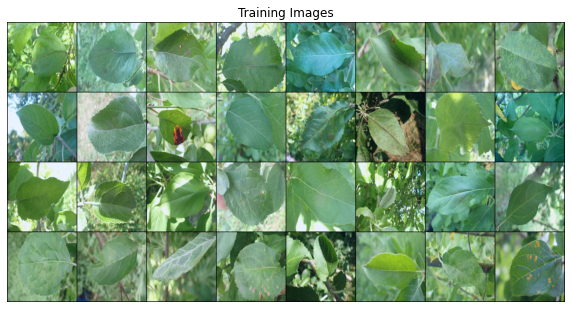

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],padding=2,normalize=True).cpu(),(1,2,0)));

In [ ]:
from torchvision import models
import torch.optim as optim

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optim = optim.Adam(model_ft.parameters(), lr=0.00001)


In [ ]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth'))

In [ ]:
def train(R,optim,cri):
 
  for epoch in range(3):
    for index,sample in enumerate(train_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      optim.zero_grad()
      cost.backward()
      optim.step()
      if index%10==0:
        print('epoch {} , cost: {:.4f}'.format(epoch,cost.item()))
        test(R,cri)
        R.train()
      torch.save(R.state_dict(),'/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth')

In [ ]:
def test(R,cri):
  R.eval()
  correct=0
  loss_avg=0
  with torch.no_grad():
    for index,sample in enumerate(test_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      loss_avg+=cost.item()
      prediction=out.max(1,keepdim=True)[1]
      correct+=prediction.eq(Y.view_as(prediction)).sum().item()
      


  test_accuracy=100*correct/len(test_loader.dataset)
  loss_avg/=len(test_loader.dataset)
  print('cost: {:.2f}%'.format(test_accuracy))
  print('loss_avg:',loss_avg)

In [ ]:
train(model_ft,optim,criterion)

epoch 0 , cost: 0.9313
cost: 72.24%
loss_avg: 0.03062224242381832
epoch 0 , cost: 0.2508
cost: 83.33%
loss_avg: 0.015431993067777962
epoch 0 , cost: 0.4516
cost: 83.08%
loss_avg: 0.015125392691629998
epoch 0 , cost: 0.4718
cost: 85.05%
loss_avg: 0.014262421416322136
epoch 0 , cost: 0.4414
cost: 85.11%
loss_avg: 0.01360715281867292
epoch 0 , cost: 0.2601
cost: 86.25%
loss_avg: 0.013544008363515478
epoch 0 , cost: 0.4870
cost: 86.58%
loss_avg: 0.013302314743942008
epoch 0 , cost: 0.5054
cost: 86.41%
loss_avg: 0.012866662451378933
epoch 0 , cost: 0.3961
cost: 86.72%
loss_avg: 0.012622277300766555
epoch 0 , cost: 0.4520
cost: 86.52%
loss_avg: 0.01277467087180325
epoch 0 , cost: 0.6776
cost: 86.72%
loss_avg: 0.01254310965471779
epoch 0 , cost: 0.3939
cost: 86.61%
loss_avg: 0.012498726978769697
epoch 0 , cost: 0.5115
cost: 85.75%
loss_avg: 0.01256266579955245
epoch 0 , cost: 0.6734
cost: 85.66%
loss_avg: 0.013230768712685154
epoch 0 , cost: 0.7316
cost: 87.16%
loss_avg: 0.012157051637458218
